<a href="https://colab.research.google.com/github/Ak4nksha/ai-generated-text-detector/blob/main/notebooks/04_lstm_sequence_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Sequence Model

**Objective:**
Train a Deep Learning sequence model (LSTM) to detect AI-generated text. Unlike the feature-based models in Notebook 3 which relied on manual counts (like sentence length), this model learns patterns directly from the raw sequence of words.

**Key Components:**
1.  **Load Fixed Splits:** Import the pre-split data (`train.csv`, `val.csv`, `test.csv`) saved in Notebook 3 to ensure we are testing on the exact same "Collected" dataset.
2.  **Preprocessing:**
    * **Tokenization:** Custom regex tokenizer to split text into words.
    * **Vocabulary:** Built *strictly* on the Training set to prevent data leakage.
    * **Sequence Handling:** Implements padding and "packed sequences" to handle variable-length text efficiently in PyTorch.
3.  **Model Architecture:**
    * **Embedding Layer:** Converts words into dense vectors.
    * **Bi-LSTM:** Bidirectional Long Short-Term Memory layer to capture context from both past and future words.
    * **Classifier:** Fully connected layer with Dropout for regularization.
4.  **Training Loop:**
    * Uses **AdamW** optimizer and **BCEWithLogitsLoss**.
    * Implements **Early Stopping** based on Validation F1-score to prevent overfitting.
5.  **Final Evaluation:** Reports strict accuracy and F1 metrics on the held-out Test set (Scraped Data).

In [1]:
# === LOAD FIXED SPLITS (created in notebook 03) ===

from google.colab import drive
drive.mount("/content/drive")

from pathlib import Path
import pandas as pd
import numpy as np

SPLITS_DIR = Path("/content/drive/MyDrive/artifacts/splits_v1")

train_path = SPLITS_DIR / "train.csv"
val_path   = SPLITS_DIR / "val.csv"
test_path  = SPLITS_DIR / "test.csv"

train_df = pd.read_csv(train_path)
val_df   = pd.read_csv(val_path)
test_df  = pd.read_csv(test_path)

# Ensure expected columns exist
for name, df in [("train", train_df), ("val", val_df), ("test", test_df)]:
    if "text" not in df.columns or "label" not in df.columns:
        raise ValueError(f"{name}.csv must contain columns: text, label")

# Labels as numpy arrays
y_train = train_df["label"].astype(int).values
y_val   = val_df["label"].astype(int).values
y_test  = test_df["label"].astype(int).values

print(" Loaded splits from:", SPLITS_DIR)
print("Sizes:", len(train_df), len(val_df), len(test_df))
print("Label dist train:", np.bincount(y_train))
print("Label dist val:  ", np.bincount(y_val))
print("Label dist test: ", np.bincount(y_test))


Mounted at /content/drive
 Loaded splits from: /content/drive/MyDrive/artifacts/splits_v1
Sizes: 32617 5756 1627
Label dist train: [16697 15920]
Label dist val:   [2946 2810]
Label dist test:  [ 357 1270]


In [24]:
train_df

,text,label,split
0,"On the matter of ""driverless cars"", I would ad...",0,train
1,"Dear, Manager Hate you ever had a dream job? I...",0,train
2,"Dear Principal, I think the new policy sounds ...",0,train
3,Mar's Face Many people think that Mars has lif...,0,train
4,"Cars, they help us get from point A to B in a ...",0,train
...,...,...,...
32612,Our facial expressions can tell someone a lot ...,0,train
32613,Whether young people enjoy life more than olde...,1,train
32614,The author has said that NASA has three pictur...,0,train
32615,"Dear Principal, I believe it would be better i...",0,train


In [15]:
# =========================
# LSTM text classifier
#   TRAIN/VAL = Kaggle only
#   TEST      = Scraped only
#
# Uses PyTorch. Includes:
# - fast regex tokenization
# - vocab built from TRAIN only
# - truncation to max_len
# - padding + packed sequences
# - early stopping on VAL F1
# - per-epoch timing
#
# datasets:
#   train_df, val_df, test_df
#   y_train, y_val, y_test
#
# This code prints time/epoch + a simple projected total after epoch 1.
# =========================

import re
import time
import math
import numpy as np
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# -------------------------
# Config (tune these first)
# -------------------------
SEED = 42
MAX_VOCAB = 50_000        # 30k–100k typical
MIN_FREQ = 2              # drop very rare tokens, since we want to focus on statistical construct of the text
MAX_LEN = 384             # 256/384/512. Higher = slower but captures longer context
BATCH_SIZE = 32           # 32/64/128 depending on CPU & RAM
EMB_DIM = 192             # 128–256
HID_DIM = 192             # 128–256
NUM_LAYERS = 1            # 1–2 (2 slower)
BIDIR = True
DROPOUT = 0.2
LR = 2e-3
EPOCHS = 8
PATIENCE = 4              # early stop if VAL F1 doesn't improve
CLIP = 1.0

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# -------------------------
# Reproducibility
# -------------------------
torch.manual_seed(SEED)
np.random.seed(SEED)

# -------------------------
# Tokenizer (fast, stable)
# -------------------------
_tok = re.compile(r"[A-Za-z0-9]+(?:'[A-Za-z0-9]+)?|[^\sA-Za-z0-9]")
def tokenize(text: str):
    return _tok.findall((text or "").lower())

# -------------------------
# Build vocab from TRAIN only
# -------------------------
def build_vocab(texts, max_vocab=MAX_VOCAB, min_freq=MIN_FREQ):
    counter = Counter()
    for t in texts:
        counter.update(tokenize(t))
    # Special tokens
    itos = ["<pad>", "<unk>"]
    # Keep most common above min_freq
    for tok, freq in counter.most_common():
        if freq < min_freq:
            break
        itos.append(tok)
        if len(itos) >= max_vocab:
            break
    stoi = {tok: i for i, tok in enumerate(itos)}
    return stoi, itos

train_texts = train_df["text"].astype(str).tolist()
val_texts   = val_df["text"].astype(str).tolist()
test_texts  = test_df["text"].astype(str).tolist()

stoi, itos = build_vocab(train_texts)
PAD_IDX = stoi["<pad>"]
UNK_IDX = stoi["<unk>"]

print(f"Vocab size: {len(itos):,} (PAD={PAD_IDX}, UNK={UNK_IDX})")

# -------------------------
# Dataset + Collate
# -------------------------
def encode(text: str, max_len=MAX_LEN):
    ids = [stoi.get(tok, UNK_IDX) for tok in tokenize(text)]
    if len(ids) > max_len:
        ids = ids[:max_len]
    return ids

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels.astype(np.int64)
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, i):
        return self.texts[i], self.labels[i]

def collate_batch(batch):
    texts, labels = zip(*batch)
    seqs = [torch.tensor(encode(t), dtype=torch.long) for t in texts]
    lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)

    # pad to max length in batch
    maxl = int(lengths.max().item()) if len(lengths) else 1
    padded = torch.full((len(seqs), maxl), PAD_IDX, dtype=torch.long)
    for i, s in enumerate(seqs):
        padded[i, :len(s)] = s

    labels = torch.tensor(labels, dtype=torch.float32)  # binary
    return padded.to(DEVICE), lengths.to(DEVICE), labels.to(DEVICE)

train_ds = TextDataset(train_texts, y_train)
val_ds   = TextDataset(val_texts, y_val)
test_ds  = TextDataset(test_texts, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_batch)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

Using device: cuda
Vocab size: 36,261 (PAD=0, UNK=1)


In [16]:
# Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, num_layers, bidir, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidir,
            dropout=0.0 if num_layers == 1 else dropout
        )
        out_dim = hid_dim * (2 if bidir else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(out_dim, 1)

    def forward(self, x, lengths):
        # x: [B, T]
        emb = self.dropout(self.embedding(x))  # [B, T, E]

        # pack sequences for speed
        lengths_cpu = lengths.to("cpu")
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths_cpu, batch_first=True, enforce_sorted=False)
        packed_out, (h, c) = self.lstm(packed)

        # h shape: [num_layers * num_directions, B, H]
        if self.lstm.bidirectional:
            # last layer forward + backward
            h_f = h[-2, :, :]
            h_b = h[-1, :, :]
            h_cat = torch.cat([h_f, h_b], dim=1)  # [B, 2H]
        else:
            h_cat = h[-1, :, :]  # [B, H]

        logits = self.fc(self.dropout(h_cat)).squeeze(1)  # [B]
        return logits

model = LSTMClassifier(
    vocab_size=len(itos),
    emb_dim=EMB_DIM,
    hid_dim=HID_DIM,
    num_layers=NUM_LAYERS,
    bidir=BIDIR,
    dropout=DROPOUT,
    pad_idx=PAD_IDX
).to(DEVICE)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

In [17]:
# -------------------------
# Metrics helpers
# -------------------------
@torch.no_grad()
def predict_loader(loader):
    model.eval()
    all_probs, all_y = [], []
    for x, lengths, y in loader:
        logits = model(x, lengths)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        all_probs.append(probs)
        all_y.append(y.detach().cpu().numpy())
    probs = np.concatenate(all_probs) if all_probs else np.array([])
    ytrue = np.concatenate(all_y).astype(int) if all_y else np.array([], dtype=int)
    return probs, ytrue

def eval_split(loader, threshold=0.5):
    probs, ytrue = predict_loader(loader)
    ypred = (probs >= threshold).astype(int)
    acc = accuracy_score(ytrue, ypred)
    p, r, f1, _ = precision_recall_fscore_support(ytrue, ypred, average="binary", zero_division=0)
    return acc, p, r, f1


In [21]:
# -------------------------
# Train loop with timing + early stopping
# -------------------------
best_val_f1 = -1.0
best_state = None
no_improve = 0
epoch_times = []

for epoch in range(1, EPOCHS + 1):
    train_loss_hist = []
    val_f1_hist = []
    val_acc_hist = []
    t0 = time.time()
    model.train()
    running_loss = 0.0
    n_batches = 0

    for x, lengths, y in train_loader:
        optimizer.zero_grad()
        logits = model(x, lengths)
        loss = criterion(logits, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()

        running_loss += float(loss.item())
        n_batches += 1

    train_loss = running_loss / max(n_batches, 1)
    val_acc, val_p, val_r, val_f1 = eval_split(val_loader)

    t1 = time.time()
    epoch_sec = t1 - t0
    epoch_times.append(epoch_sec)
    train_loss_hist.append(train_loss)
    val_f1_hist.append(val_f1)
    val_acc_hist.append(val_acc)


    # After epoch 1, print a rough projection based on observed time/epoch
    if epoch == 1:
        projected = epoch_sec * EPOCHS
        print(f"\n[Timing] Epoch 1 took {epoch_sec:.1f}s. Rough projected total for {EPOCHS} epochs: ~{projected/60:.1f} min (before early stopping).")

    print(f"Epoch {epoch}/{EPOCHS} | train_loss={train_loss:.4f} | "
          f"VAL acc={val_acc:.4f} p={val_p:.4f} r={val_r:.4f} f1={val_f1:.4f} | "
          f"time={epoch_sec:.1f}s")

    # Early stopping on VAL F1
    if val_f1 > best_val_f1 + 1e-4:
        best_val_f1 = val_f1
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"Early stopping: no VAL F1 improvement for {PATIENCE} epoch(s).")
            break

# Restore best model
if best_state is not None:
    model.load_state_dict(best_state)


[Timing] Epoch 1 took 40.7s. Rough projected total for 8 epochs: ~5.4 min (before early stopping).
Epoch 1/8 | train_loss=0.0046 | VAL acc=0.9906 p=0.9918 r=0.9890 f1=0.9904 | time=40.7s
Epoch 2/8 | train_loss=0.0039 | VAL acc=0.9908 p=0.9928 r=0.9883 f1=0.9905 | time=41.7s
Epoch 3/8 | train_loss=0.0048 | VAL acc=0.9910 p=0.9907 r=0.9907 f1=0.9907 | time=41.3s
Epoch 4/8 | train_loss=0.0044 | VAL acc=0.9918 p=0.9901 r=0.9932 f1=0.9917 | time=40.7s
Epoch 5/8 | train_loss=0.0016 | VAL acc=0.9924 p=0.9908 r=0.9936 f1=0.9922 | time=40.4s
Epoch 6/8 | train_loss=0.0021 | VAL acc=0.9929 p=0.9950 r=0.9904 f1=0.9927 | time=40.2s
Epoch 7/8 | train_loss=0.0024 | VAL acc=0.9929 p=0.9936 r=0.9918 f1=0.9927 | time=40.5s
Epoch 8/8 | train_loss=0.0014 | VAL acc=0.9925 p=0.9936 r=0.9911 f1=0.9923 | time=45.2s


In [19]:
# -------------------------
# Final evaluation
# -------------------------
val_acc, val_p, val_r, val_f1 = eval_split(val_loader)
test_acc, test_p, test_r, test_f1 = eval_split(test_loader)

print("\n===== FINAL (best checkpoint) =====")
print(f"VAL  acc={val_acc:.4f} p={val_p:.4f} r={val_r:.4f} f1={val_f1:.4f}")
print(f"TEST acc={test_acc:.4f} p={test_p:.4f} r={test_r:.4f} f1={test_f1:.4f}")
print(f"Avg time/epoch: {np.mean(epoch_times):.1f}s over {len(epoch_times)} epoch(s)")


===== FINAL (best checkpoint) =====
VAL  acc=0.9917 p=0.9943 r=0.9886 f1=0.9914
TEST acc=0.7271 p=0.7963 r=0.8740 f1=0.8333
Avg time/epoch: 41.1s over 8 epoch(s)


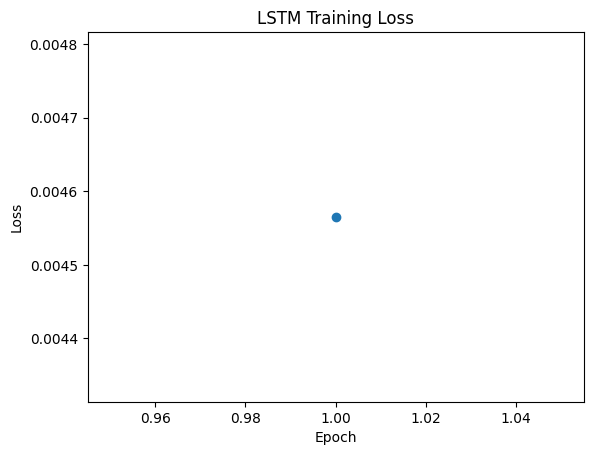

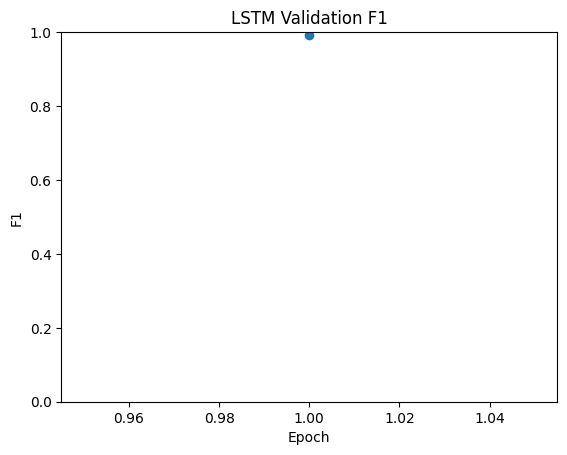


=== LSTM Compact Metrics (thr=0.5) ===


,split,acc,prec,rec,f1,roc_auc,pr_auc
0,VAL,0.9917,0.9943,0.9886,0.9914,0.9991,0.9991
1,TEST,0.7271,0.7963,0.8740,0.8333,0.7319,0.9059


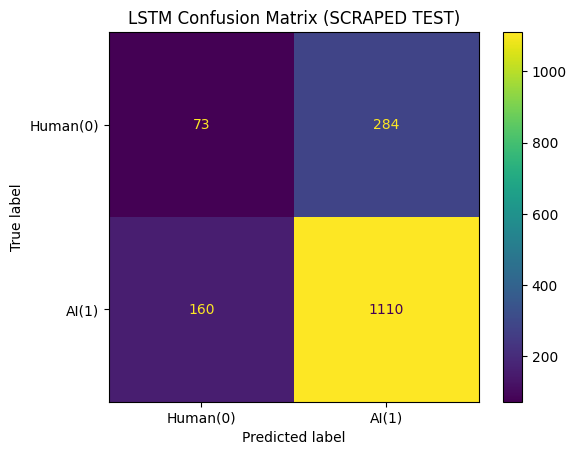

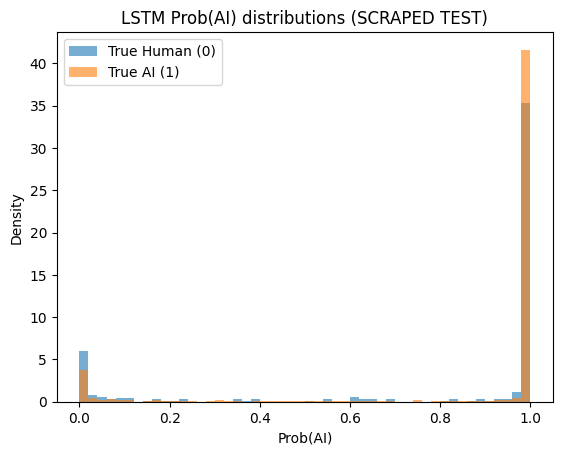

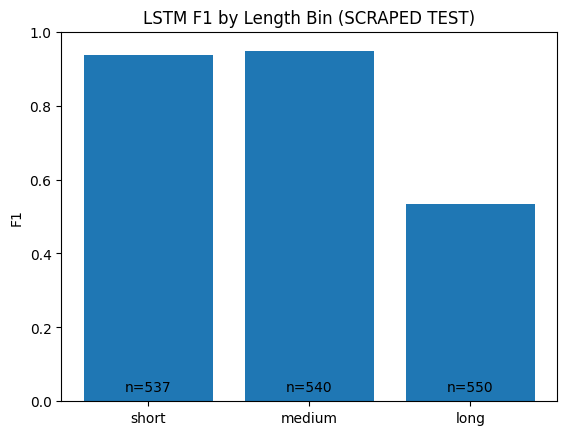

KeyError: 'source'

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_fscore_support, accuracy_score,
    roc_auc_score, average_precision_score
)

# -------------------------
# 1) Evaluate on a loader (return probs + labels)
# -------------------------
@torch.no_grad()
def lstm_probs_on_loader(loader):
    model.eval()
    all_probs, all_y = [], []
    for x, lengths, y in loader:
        logits = model(x, lengths)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        all_probs.append(probs)
        all_y.append(y.detach().cpu().numpy())
    probs = np.concatenate(all_probs) if all_probs else np.array([])
    ytrue = np.concatenate(all_y).astype(int) if all_y else np.array([], dtype=int)
    return probs, ytrue

def metrics_from_probs(ytrue, probs, thr=0.5):
    ypred = (probs >= thr).astype(int)
    acc = accuracy_score(ytrue, ypred)
    p, r, f1, _ = precision_recall_fscore_support(ytrue, ypred, average="binary", zero_division=0)

    out = {"acc": acc, "prec": p, "rec": r, "f1": f1}
    try: out["roc_auc"] = roc_auc_score(ytrue, probs)
    except Exception: out["roc_auc"] = np.nan
    try: out["pr_auc"]  = average_precision_score(ytrue, probs)
    except Exception: out["pr_auc"]  = np.nan
    return out, ypred

# -------------------------
# 2) Plots
# -------------------------
def plot_training_curves(train_loss_hist, val_f1_hist):
    epochs = np.arange(1, len(train_loss_hist) + 1)

    fig, ax = plt.subplots()
    ax.plot(epochs, train_loss_hist, marker="o")
    ax.set_title("LSTM Training Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(epochs, val_f1_hist, marker="o")
    ax.set_title("LSTM Validation F1")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("F1")
    ax.set_ylim(0, 1)
    plt.show()

def plot_confidence_distributions(ytrue, probs, marker_prob=None):
    p_h = probs[ytrue == 0]
    p_a = probs[ytrue == 1]
    bins = np.linspace(0, 1, 51)

    fig, ax = plt.subplots()
    ax.hist(p_h, bins=bins, alpha=0.6, density=True, label="True Human (0)")
    ax.hist(p_a, bins=bins, alpha=0.6, density=True, label="True AI (1)")
    if marker_prob is not None:
        ax.axvline(marker_prob, linestyle="--", linewidth=2)
        ax.text(marker_prob, ax.get_ylim()[1]*0.95, "Custom input", rotation=90, va="top")
    ax.set_title("LSTM Prob(AI) distributions (SCRAPED TEST)")
    ax.set_xlabel("Prob(AI)")
    ax.set_ylabel("Density")
    ax.legend()
    plt.show()

def plot_length_bin_f1(test_df, ytrue, probs, thr=0.5):
    lens = test_df["text"].astype(str).str.len()
    q1, q2 = lens.quantile([0.33, 0.66]).values
    bins = pd.cut(lens, [-np.inf, q1, q2, np.inf], labels=["short","medium","long"]).astype(str)

    ypred = (probs >= thr).astype(int)

    labels = ["short","medium","long"]
    f1s, counts = [], []
    for b in labels:
        m = (bins == b).values
        counts.append(int(m.sum()))
        if m.sum() == 0:
            f1s.append(np.nan)
        else:
            _, _, f1, _ = precision_recall_fscore_support(ytrue[m], ypred[m], average="binary", zero_division=0)
            f1s.append(float(f1))

    fig, ax = plt.subplots()
    ax.bar(labels, f1s)
    ax.set_ylim(0, 1)
    ax.set_ylabel("F1")
    ax.set_title("LSTM F1 by Length Bin (SCRAPED TEST)")
    for i, c in enumerate(counts):
        ax.text(i, 0.02, f"n={c}", ha="center", va="bottom")
    plt.show()

def per_source_table(test_df, ytrue, probs, thr=0.5, min_n=20):
    ypred = (probs >= thr).astype(int)
    rows = []
    for src, idx in test_df.groupby("source").indices.items():
        idx = np.array(list(idx))
        if len(idx) < min_n:
            continue
        m, _ = metrics_from_probs(ytrue[idx], probs[idx], thr=thr)
        rows.append({"source": src, "n": len(idx), **m})
    out = pd.DataFrame(rows).sort_values("f1", ascending=False)
    print(f"\n=== LSTM per-source performance (SCRAPED TEST, min_n={min_n}) ===")
    display(out.round(4))
    return out

def show_confident_errors(test_df, ytrue, probs, topk=10):
    df_err = test_df.copy().reset_index(drop=True)
    df_err["y_true"] = ytrue
    df_err["prob_ai"] = probs
    df_err["y_pred"] = (probs >= 0.5).astype(int)
    df_err["correct"] = (df_err["y_true"] == df_err["y_pred"])

    fp = df_err[(df_err["y_true"] == 0) & (df_err["y_pred"] == 1)].sort_values("prob_ai", ascending=False).head(topk)
    fn = df_err[(df_err["y_true"] == 1) & (df_err["y_pred"] == 0)].sort_values("prob_ai", ascending=True).head(topk)

    print(f"\n=== Top {topk} confident FALSE POSITIVES (Human predicted AI) ===")
    display(fp[["source","prob_ai","text"]].assign(text=fp["text"].str.slice(0, 300) + "..."))

    print(f"\n=== Top {topk} confident FALSE NEGATIVES (AI predicted Human) ===")
    display(fn[["source","prob_ai","text"]].assign(text=fn["text"].str.slice(0, 300) + "..."))

# -------------------------
# 3) Run dashboard
# -------------------------
# training curves (only if you logged these in Cell 1)
if "train_loss_hist" in globals() and "val_f1_hist" in globals():
    plot_training_curves(train_loss_hist, val_f1_hist)
else:
    print("No training curves found. Add train_loss_hist / val_f1_hist logging as suggested.")

# evaluate val + test
val_probs, val_ytrue = lstm_probs_on_loader(val_loader)
test_probs, test_ytrue = lstm_probs_on_loader(test_loader)

val_m, _ = metrics_from_probs(val_ytrue, val_probs, thr=0.5)
test_m, test_pred = metrics_from_probs(test_ytrue, test_probs, thr=0.5)

print("\n=== LSTM Compact Metrics (thr=0.5) ===")
display(pd.DataFrame([
    {"split":"VAL",  **val_m},
    {"split":"TEST", **test_m},
]).round(4))

# confusion matrix on scraped test
cm = confusion_matrix(test_ytrue, test_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=["Human(0)","AI(1)"])
fig, ax = plt.subplots()
disp.plot(ax=ax, values_format="d")
ax.set_title("LSTM Confusion Matrix (SCRAPED TEST)")
plt.show()

# confidence distributions
plot_confidence_distributions(test_ytrue, test_probs)

# length-bin performance
plot_length_bin_f1(test_df.reset_index(drop=True), test_ytrue, test_probs, thr=0.5)

# per-source
per_source_table(test_df.reset_index(drop=True), test_ytrue, test_probs, thr=0.5, min_n=20)

# confident errors
show_confident_errors(test_df.reset_index(drop=True), test_ytrue, test_probs, topk=10)

# expose test_probs for custom input overlay later
LSTM_TEST_PROBS = test_probs
LSTM_TEST_YTRUE = test_ytrue